<a href="https://colab.research.google.com/github/clyde2020/ML_Portfolio/blob/main/Cassava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
import random
!pip install keras-tuner -q
from keras_tuner import RandomSearch
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import pickle
from keras.models import load_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from keras.callbacks import ReduceLROnPlateau
import cv2
from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array, to_categorical

from google.colab import drive
drive.mount('/content/gdrive')

     |████████████████████████████████| 98 kB 3.0 MB/s 
Mounted at /content/gdrive


## Initialize variables

In [2]:
home_dir = '/content/gdrive/MyDrive/Cassava'
source_folder = '{}/train_images'.format(home_dir)
df = pd.read_csv('{}/train.csv'.format(home_dir))
label_map = pd.read_json('{}/label_num_to_disease_map.json'.format(home_dir), orient='index')
state = 32
batch_size = 16

picdict = dict(zip(df['image_id'], df['label']))

## View Image

In [3]:
def imager(path):
  im_bgr = cv2.imread(path)
  im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)
  # im_rgb = im_bgr[:, :, ::-1]
  return im_rgb

def view_image(path):
  file = path.split(sep='/')[-1]
  name_val = df[df['image_id'] == file]['label'].values[0]
  name = label_map.loc[name_val].values[0]
  plt.imshow(image)
  plt.title(name)
  plt.show()

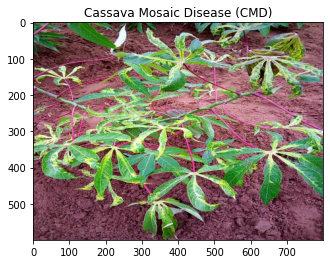

(600, 800, 3)


In [4]:
path = '/content/gdrive/MyDrive/Cassava/Train/3/1093739814.jpg'
image = imager(path=path)
view_image(path=path)

print(image.shape)

In [5]:
image_size_reducer = 0.25
image_shape = (int(image.shape[0] * image_size_reducer),
               int(image.shape[1] * image_size_reducer),
               image.shape[2])
channels = image_shape[2]

In [6]:
print(df.head(3))
print(' ')
print(df.label.value_counts())

         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
 
3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64


## Process data for transfer model

In [7]:
import keras
from keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import (BatchNormalization, Dense, Lambda, Input, 
                                     GlobalAveragePooling2D, Dropout, Flatten,
                                     Concatenate)

In [19]:
def get_model(pretrained_model):
  input = Input(shape=image_shape)
  if pretrained_model == 'inception':
    pretrained_model = InceptionV3(include_top=False,
                                   input_tensor=input,
                                   weights='imagenet')
  elif pretrained_model == 'xception':
    pretrained_model = Xception(include_top=False,
                                input_tensor=input,
                                weights='imagenet')
  elif pretrained_model == 'resnet50':
    pretrained_model = ResNet50(include_top=False,
                                input_tensor=input,
                                weights='imagenet')
  elif pretrained_model == 'vgg16':
    pretrained_model = VGG16(include_top=False,
                                input_tensor=input,
                                weights='imagenet')
  elif pretrained_model == 'all':
    inception_model = InceptionV3(include_top=False,
                                  input_tensor=input,
                                  weights='imagenet')
    xception_model = Xception(include_top=False,
                              input_tensor=input,
                              weights='imagenet')
    resnet_model = ResNet50(include_top=False,
                            input_tensor=input,
                            weights='imagenet')
    flattened_outputs = [Flatten()(inception_model.output),
                         Flatten()(xception_model.output),
                         Flatten()(resnet_model.output)]
    output = Concatenate()(flattened_outputs)
    pretrained_model = Model(input, output)
  
  output = Flatten()(pretrained_model.output)

  output = BatchNormalization()(output)
  output = Dropout(0.5)(output)
  output = Dense(128, activation='relu')(output)

  output = BatchNormalization()(output)
  output = Dropout(0.5)(output)
  output = Dense(5, activation='softmax')(output)

  model = Model(pretrained_model.input, output)

  for layer in pretrained_model.layers:
    layer.trainable = False
  
  return model

In [23]:
model = get_model('all')

In [16]:
model.input.shape, model.output.shape

(TensorShape([None, 150, 200, 3]), TensorShape([None, 5]))

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-2)

# model.compile(optimizer=optimizer, 
#               loss='sparse_categorical_crossentropy', 
#               metrics=['acc']
#               )

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['acc']
              )

reduce_lr = ReduceLROnPlateau(monitor='acc',
                              factor=0.5,
                              patience=1,
                              cooldown=2,
                              min_lr=5e-4
                              )

mc = ModelCheckpoint(monitor='val_acc', 
                     filepath='{}/Saved_data/Transfer_bestmodel_011622.h5'.format(home_dir), 
                     verbose=1, 
                     save_best_only=True, 
                     mode='max'
                     )

cd = [reduce_lr, mc]

In [29]:
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=valid_generator,
                    callbacks=cd
                    )

Epoch 1/20
581/581 [==============================] - ETA: 0s - loss: 1.4691 - acc: 0.3898
Epoch 00001: val_acc improved from -inf to 0.35140, saving model to /content/gdrive/MyDrive/Cassava/Saved_data/Transfer_bestmodel_011622.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


581/581 [==============================] - 379s 634ms/step - loss: 1.4691 - acc: 0.3898 - val_loss: 24.5634 - val_acc: 0.3514 - lr: 0.0500
Epoch 2/20
581/581 [==============================] - ETA: 0s - loss: 1.4605 - acc: 0.3874
Epoch 00002: val_acc improved from 0.35140 to 0.47919, saving model to /content/gdrive/MyDrive/Cassava/Saved_data/Transfer_bestmodel_011622.h5
581/581 [==============================] - 361s 621ms/step - loss: 1.4605 - acc: 0.3874 - val_loss: 26.3874 - val_acc: 0.4792 - lr: 0.0500
Epoch 3/20
581/581 [==============================] - ETA: 0s - loss: 1.3064 - acc: 0.4487
Epoch 00003: val_acc improved from 0.47919 to 0.49855, saving model to /content/gdrive/MyDrive/Cassava/Saved_data/Transfer_bestmodel_011622.h5
581/581 [==============================] - 357s 614ms/step - loss: 1.3064 - acc: 0.4487 - val_loss: 4.4940 - val_acc: 0.4985 - lr: 0.0250
Epoch 4/20
581/581 [==============================] - ETA: 0s - loss: 1.2911 - acc: 0.4623
Epoch 00004: val_acc impr

# Set up flow_from_dataframe

## Process data

In [12]:
# Get sample dataframes of each class
sample = 2350

df_0 = df[df['label'] == 0]
df_1 = df[df['label'] == 1]
df_2 = df[df['label'] == 2].sample(sample)
df_3 = df[df['label'] == 3].sample(sample)
df_4 = df[df['label'] == 4].sample(sample)

# Get train, test split
df_sample = pd.concat([df_0, df_1, df_2, df_3, df_4], axis=0).reset_index(drop=True)
df_train, df_valid = train_test_split(df_sample, 
                                      test_size=.1, 
                                      random_state=state, 
                                      stratify=df_sample['label'])

# Set up train dataframe for one-hot categorical labels
df_onehot_train = pd.get_dummies(df_train['label'])
df_train = pd.concat([df_train, df_onehot_train], axis=1)
df_train.drop('label', axis=1, inplace=True)
cols = list(df_onehot_train.columns)

# Set up valid dataframe for one-hot categorical labels
df_onehot_valid = pd.get_dummies(df_valid['label'])
df_valid = pd.concat([df_valid, df_onehot_valid], axis=1)
df_valid.drop('label', axis=1, inplace=True)

In [13]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                  rotation_range=45,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                   )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='{}/train_images'.format(home_dir),
    x_col='image_id',
    y_col=cols,
    target_size=(image_shape[0], 
                 image_shape[1]),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=True,
    seed=state)

valid_datagen = ImageDataGenerator(rescale=1/255.0)  

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=df_valid,
    directory='{}/train_images'.format(home_dir),
    x_col='image_id',
    y_col=cols,
    target_size=(image_shape[0], 
                 image_shape[1]),
    batch_size=batch_size,
    class_mode='raw',
    shuffle=True,
    seed=state)

Found 9292 validated image filenames.
Found 1033 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# Set up flow_from_directory

## Process data

In [ ]:
train_comp = '{}/Train7_3000'.format(home_dir)
valid_comp = '{}/Valid7_3000'.format(home_dir)
train_0 = '{}/0'.format(train_comp)
train_1 = '{}/1'.format(train_comp)
train_2 = '{}/2'.format(train_comp)
train_3 = '{}/3'.format(train_comp)
train_4 = '{}/4'.format(train_comp)
valid_0 = '{}/0'.format(valid_comp)
valid_1 = '{}/1'.format(valid_comp)
valid_2 = '{}/2'.format(valid_comp)
valid_3 = '{}/3'.format(valid_comp)
valid_4 = '{}/4'.format(valid_comp)

def split_data(LIST, FOL0, FOL1, FOL2, FOL3, FOL4):
  for fname in LIST:
    origin = os.path.join(source_folder, fname)
    if picdict[fname] == 0:
      shutil.copy(src=origin, dst=FOL0)
    elif picdict[fname] == 1:
      shutil.copy(src=origin, dst=FOL1)
    elif picdict[fname] == 2:
      shutil.copy(src=origin, dst=FOL2)
    elif picdict[fname] == 3:
      shutil.copy(src=origin, dst=FOL3)
    else:
      shutil.copy(src=origin, dst=FOL4)

In [ ]:
sample = 3000

df_0 = df[df['label'] == 0]
df_1 = df[df['label'] == 1]
df_2 = df[df['label'] == 2]
df_3 = df[df['label'] == 3].sample(sample)
df_4 = df[df['label'] == 4]

df_sample = pd.concat([df_0, df_1, df_2, df_3, df_4], axis=0).reset_index(drop=True)
df_train, df_valid = train_test_split(df_sample, 
                                      test_size=.1, 
                                      random_state=state, 
                                      stratify=df_sample['label'])
train_list = list(df_train['image_id'])
valid_list = list(df_valid['image_id'])

In [ ]:
os.mkdir(train_comp)
os.mkdir(valid_comp)
os.mkdir(train_0)
os.mkdir(train_1)
os.mkdir(train_2)
os.mkdir(train_3)
os.mkdir(train_4)
os.mkdir(valid_0)
os.mkdir(valid_1)
os.mkdir(valid_2)
os.mkdir(valid_3)
os.mkdir(valid_4)

In [ ]:
split_data(valid_list, valid_0, valid_1, valid_2, valid_3, valid_4)
split_data(train_list, train_0, train_1, train_2, train_3, train_4)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                  rotation_range=45,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_comp,
    target_size=(int((image_shape[0] * image_size_reducer)), 
                 int((image_shape[1] * image_size_reducer))),
    batch_size=batch_size,
    class_mode='sparse')

validation_datagen = ImageDataGenerator(rescale=1/255.0)  

valid_generator = validation_datagen.flow_from_directory(
    valid_comp,
    target_size=(int((image_shape[0] * image_size_reducer)), 
                 int((image_shape[1] * image_size_reducer))),
    batch_size=batch_size,
    class_mode='sparse') 

Found 10115 images belonging to 5 classes.
Found 1124 images belonging to 5 classes.


# Transfer model

In [ ]:
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)
base_model.trainable = False

83697664/83683744 [==============================] - 0s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=(int((image_shape[0] * image_size_reducer)), 
                               int((image_shape[1] * image_size_reducer)),
                               channels))
x = base_model(inputs)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
eff_model = tf.keras.Model(inputs, outputs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

eff_model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc']
              )

reduce_lr = ReduceLROnPlateau(monitor='acc',
                              factor=0.5,
                              patience=1,
                              cooldown=2,
                              min_lr=1e-4
                              )

mc = ModelCheckpoint(monitor='val_acc', 
                     filepath='{}/Saved_data/Transfer_bestmodel_011122.h5'.format(home_dir), 
                     verbose=1, 
                     save_best_only=True, 
                     mode='max'
                     )

cd = [reduce_lr, mc]

In [ ]:
eff_model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=valid_generator,
                    callbacks=cd
                    )

Epoch 1/20
507/507 [==============================] - ETA: 0s - loss: 4.1264 - acc: 0.3869
Epoch 00001: val_acc improved from -inf to 0.44444, saving model to /content/gdrive/MyDrive/Cassava/Saved_data/Transfer_bestmodel_011122.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


507/507 [==============================] - 480s 941ms/step - loss: 4.1264 - acc: 0.3869 - val_loss: 3.3351 - val_acc: 0.4444 - lr: 0.0100
Epoch 2/20
507/507 [==============================] - ETA: 0s - loss: 4.3955 - acc: 0.4262
Epoch 00002: val_acc improved from 0.44444 to 0.45667, saving model to /content/gdrive/MyDrive/Cassava/Saved_data/Transfer_bestmodel_011122.h5
507/507 [==============================] - 465s 918ms/step - loss: 4.3955 - acc: 0.4262 - val_loss: 4.4742 - val_acc: 0.4567 - lr: 0.0100
Epoch 3/20
507/507 [==============================] - ETA: 0s - loss: 4.1567 - acc: 0.4577
Epoch 00003: val_acc improved from 0.45667 to 0.51889, saving model to /content/gdrive/MyDrive/Cassava/Saved_data/Transfer_bestmodel_011122.h5
507/507 [==============================] - 478s 943ms/step - loss: 4.1567 - acc: 0.4577 - val_loss: 2.9867 - val_acc: 0.5189 - lr: 0.0100
Epoch 4/20
507/507 [==============================] - ETA: 0s - loss: 4.2960 - acc: 0.4601
Epoch 00004: val_acc did no

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-3]:
  base_model.trainable = False

In [ ]:
eff_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [ ]:
eff_model.fit(train_generator,
              epochs=5,
              validation_data=validation_generator,
              verbose=1)

Epoch 1/5
282/282 [==============================] - 64s 216ms/step - loss: 1.4383 - accuracy: 0.3864 - val_loss: 1.4470 - val_accuracy: 0.3600
Epoch 2/5
282/282 [==============================] - 59s 211ms/step - loss: 1.4143 - accuracy: 0.3920 - val_loss: 1.4579 - val_accuracy: 0.3280
Epoch 3/5
282/282 [==============================] - 59s 211ms/step - loss: 1.4276 - accuracy: 0.3909 - val_loss: 1.4899 - val_accuracy: 0.3400
Epoch 4/5
282/282 [==============================] - 60s 211ms/step - loss: 1.4154 - accuracy: 0.3929 - val_loss: 1.4353 - val_accuracy: 0.3520
Epoch 5/5
282/282 [==============================] - 60s 211ms/step - loss: 1.4175 - accuracy: 0.3931 - val_loss: 1.4329 - val_accuracy: 0.3500


# Define and execute flow_from_directory 4 layer model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(state)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, 
                            kernel_size=3, 
                            input_shape=(int((image_shape[0] * image_size_reducer)), 
                               int((image_shape[1] * image_size_reducer)),
                               channels),
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=16, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=32, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=64, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    # tf.keras.layers.Conv2D(filters=64, 
    #                         kernel_size=3, 
    #                         activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    # tf.keras.layers.Conv2D(filters=64, 
    #                         kernel_size=3, 
    #                         activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    # tf.keras.layers.MaxPooling2D(2),
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=96, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc']
              )

reduce_lr = ReduceLROnPlateau(monitor='acc',
                              factor=0.5,
                              patience=1,
                              cooldown=2,
                              min_lr=1e-4
                              )

mc = ModelCheckpoint(monitor='val_acc', 
                     filepath='{}/Saved_data/4L_bestmodel_011122.h5'.format(home_dir), 
                     verbose=1, 
                     save_best_only=True, 
                     mode='max'
                     )

cd = [reduce_lr, mc]

In [ ]:
# sample = 1000, dr - 1.0, LR = 1e-2, sparse, 13 -> 0.478
# sample = 2000, dr - 0.5, LR = 1e-2, sparse, 17 -> 0.630
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=valid_generator,
                    callbacks=cd
                    )

# Define and execute flow_from_directory 6 layer model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(state)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, 
                            kernel_size=3, 
                            input_shape=(int((image_shape[0] * image_size_reducer)), 
                               int((image_shape[1] * image_size_reducer)),
                               channels),
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=16, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=32, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=32, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=64, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=64, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=96, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

model.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['acc']
              )

reduce_lr = ReduceLROnPlateau(monitor='acc',
                              factor=0.6,
                              patience=1,
                              cooldown=2,
                              min_lr=1e-4
                              )

mc = ModelCheckpoint(monitor='val_acc', 
                     filepath='{}/Saved_data/6L_bestmodel_011122.h5'.format(home_dir), 
                     verbose=1, 
                     save_best_only=True, 
                     mode='max'
                     )

cd = [reduce_lr, mc]

In [ ]:
# sample = 3000, dr - 0.5, LR = 1e-2, sparse, 19 -> 0.724
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=valid_generator,
                    callbacks=cd
                    )

Epoch 1/20
633/633 [==============================] - ETA: 0s - loss: 1.5107 - acc: 0.3246
Epoch 00001: val_acc improved from -inf to 0.23221, saving model to /content/gdrive/MyDrive/Cassava/Saved_data/6L_bestmodel_011122.h5
633/633 [==============================] - 919s 1s/step - loss: 1.5107 - acc: 0.3246 - val_loss: 1.9740 - val_acc: 0.2322 - lr: 0.0100
Epoch 2/20
633/633 [==============================] - ETA: 0s - loss: 1.3718 - acc: 0.4092
Epoch 00002: val_acc improved from 0.23221 to 0.39591, saving model to /content/gdrive/MyDrive/Cassava/Saved_data/6L_bestmodel_011122.h5
633/633 [==============================] - 870s 1s/step - loss: 1.3718 - acc: 0.4092 - val_loss: 1.4190 - val_acc: 0.3959 - lr: 0.0100
Epoch 3/20
633/633 [==============================] - ETA: 0s - loss: 1.3088 - acc: 0.4520
Epoch 00003: val_acc did not improve from 0.39591
633/633 [==============================] - 723s 1s/step - loss: 1.3088 - acc: 0.4520 - val_loss: 1.4697 - val_acc: 0.3247 - lr: 0.0100
E

# Analyze model and get predictions

In [ ]:
model = load_model('{}/Saved_data/6L_bestmodel_011122.h5'.format(home_dir))
y_pred = pd.read_csv('/content/gdrive/MyDrive/Cassava/sample_submission.csv')
test_comp = '/content/gdrive/MyDrive/Cassava/test_images'
# y_pred['id'] = y_pred['id'].apply(append_ext)


In [ ]:
y_pred

,image_id,label
0,2216849948.jpg,2


In [ ]:
test_files = pd.DataFrame({'file_name': os.listdir(test_comp)})


In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255.0)  

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=test_comp,
    x_col='file_name',
    target_size=(int((image_shape[0] * image_size_reducer)), 
                 int((image_shape[1] * image_size_reducer))),
    batch_size=1,
    class_mode=None,
    shuffle=False) 

Found 1 validated image filenames.


In [ ]:
len_test = len(test_files)
len_test

1

In [ ]:
preds = model.predict(test_generator,
                      steps=len_test,
                      verbose=1)

1/1 [==============================] - 0s 217ms/step


In [ ]:
preds = np.argmax(preds)
test_generator.filenames

['2216849948.jpg']

In [ ]:
preds

2

In [ ]:
df_submit = pd.DataFrame({'image_id': test_generator.filenames, 'label': preds})

In [ ]:
df_submit.to_csv('/content/gdrive/MyDrive/Cassava/sample_submission.csv', index=False)

# Define and execute flow_from_dataframe 6 layer model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(state)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, 
                            kernel_size=3, 
                            input_shape=(int((image_shape[0] * image_size_reducer)), 
                               int((image_shape[1] * image_size_reducer)),
                               channels),
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=16, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=32, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=32, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=48, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(filters=48, 
                            kernel_size=3, 
                            activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=96, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3)

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['acc']
              )

reduce_lr = ReduceLROnPlateau(monitor='acc',
                              factor=0.6,
                              patience=1,
                              cooldown=2,
                              min_lr=5e-5
                              )

mc = ModelCheckpoint(monitor='val_acc', 
                     filepath='{}/Saved_data/6L_bestmodel_011222.h5'.format(home_dir), 
                     verbose=1, 
                     save_best_only=True, 
                     mode='max'
                     )

cd = [reduce_lr, mc]

In [ ]:
# sample = 3000, df - 0.5, LR = 1e-2, cat, 14 -> 0.608
# sample = 2350, df - 0.5, LR = 2e-3, cat, 18 -> 0.636
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=valid_generator,
                    callbacks=cd
                    )

Epoch 1/20
581/581 [==============================] - ETA: 0s - loss: 1.5662 - acc: 0.3056
Epoch 00001: val_acc improved from -inf to 0.27880, saving model to /content/gdrive/MyDrive/Cassava/Saved_data/6L_bestmodel_011222.h5
581/581 [==============================] - 883s 2s/step - loss: 1.5662 - acc: 0.3056 - val_loss: 1.7685 - val_acc: 0.2788 - lr: 0.0020
Epoch 2/20
581/581 [==============================] - ETA: 0s - loss: 1.4213 - acc: 0.3659
Epoch 00002: val_acc improved from 0.27880 to 0.40658, saving model to /content/gdrive/MyDrive/Cassava/Saved_data/6L_bestmodel_011222.h5
581/581 [==============================] - 663s 1s/step - loss: 1.4213 - acc: 0.3659 - val_loss: 1.3935 - val_acc: 0.4066 - lr: 0.0020
Epoch 3/20
581/581 [==============================] - ETA: 0s - loss: 1.4000 - acc: 0.3817
Epoch 00003: val_acc did not improve from 0.40658
581/581 [==============================] - 663s 1s/step - loss: 1.4000 - acc: 0.3817 - val_loss: 1.5139 - val_acc: 0.2749 - lr: 0.0020
E